### Custom Loss Functions

Ledidi optimizes an objective function that is made up of two terms: the input loss, and the output loss. The input loss is, by default, an L1 loss between the original sequence and the proposed sequence and so effectively counts the number of edits that have been made. The output loss is, by default, an L2 loss between the model predictions given the edited sequence and the desired output from the model. Combined, this objective function tries to minimize the number of edits made in order to achieve a desired prediction from the model.

However, the losses do not have to be these defaults. In general, using L1 as the input loss probably makes the most conceptual sense given the formulation of Ledidi, but there may be alternatives with better convergence properties. We anticipate that the most creativity will come from using custom loss functions for the output loss, where a great deal of flexibility can be used to control the design process or work with models with interesting outputs.

#### Handling models with structured outputs

In most of our evaluations, we have either used models whose output takes the form of a count (e.g., Beluga, BPNet) or models whose output can be easily converted into something that acts like a count (e.g., Enformer, Borzoi). This is mostly because it is easy to work with models whose outputs are like this. But not all models can easily have their output converted into something that acts as a count, and even when they can, sometimes this eliminates useful information that is in the output.

For example, BPNet models make predictions for both the total counts in the region but also the basepair resolution profiles of where these counts are predicted to map to. These profiles take the form of probability distributions where the output correspond to either the probability of a read mapping to each basepair, of something like an unnormalized logit that can be easily converted to such a profile. We have been discarding these profiles because they are harder to work with, but they also provide us with the potential to finely control *where* binding sites are inserted as opposed to just *how many*.

Let's take a look. Here, we will quickly define a wrapper that pulls out the predicted profile *instead of* the predicted total counts, as we have been using before. Because the BPNet objects from bpnetlite predict logits by default, we will quickly convert those to probabilities in a numerically stable way using `log_softmax`. Note that the `ProfileWrapper` object that is built into bpnet-lite does not simply return the profile, but rather returns a conversion of the profile into a single number for use in attribution algorithms. tl;dr, do not simply use that one.

In [1]:
import torch

from bpnetlite.bpnet import ControlWrapper

class ProfileWrapper(torch.nn.Module):
    def __init__(self, model):
        super(ProfileWrapper, self).__init__()
        self.model = model
    
    def forward(self, X):
        y = self.model(X)[0]
        return torch.exp(torch.nn.functional.log_softmax(y, dim=-1))


model = torch.load("../../../../models/bpnet/GATA2.torch", weights_only=False)
model = ProfileWrapper(ControlWrapper(model))

Now that we have our model, let's generate a random sequence and apply our BPNet model to it to get a sense for what the profile predictions look like.

In [2]:
from tangermeme.utils import random_one_hot
from tangermeme.predict import predict

X = random_one_hot((1, 4, 2114), random_state=0).float()
y_hat = predict(model, X)

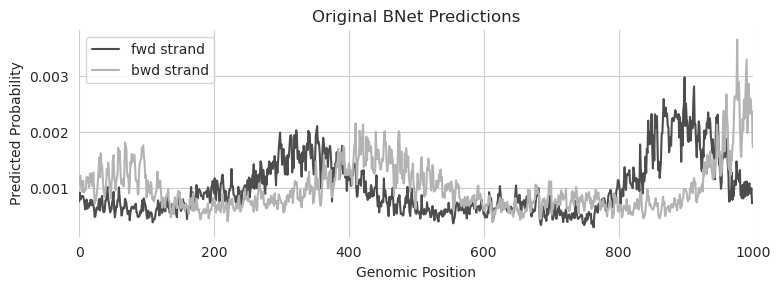

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

plt.figure(figsize=(8, 3))
plt.plot(y_hat[0, 0], c='0.3', label="fwd strand")
plt.plot(y_hat[0, 1], c='0.7', label="bwd strand")

plt.title("Original BNet Predictions")
plt.xlabel("Genomic Position")
plt.ylabel("Predicted Probability")

plt.xlim(0, 1000)
plt.legend()

seaborn.despine(bottom=True, left=True)
plt.tight_layout()
plt.show()

There are a few things to make note of here. Of course, the first is that we are no longer dealing with a single number but rather one number per position in the 1kbp output. But it's not actually one number, it's two numbers, because the profile predictions from BPNet are stranded. An important property here is that the predictions will be offset from each other because BPNet was trained on fragment starts but the binding event happens in the middle of the fragment. This means that reads mapping to the + strand will map to the left of the actual binding event and reads mapping to the - strand will map to the right of the actual binding event and that the distance to the binding event is proportional to the fragment length, which is expertiment-specific. Finally, each strand has been normalized separately and the predicted probabilities for each strand sum to 1.

These factors matter when creating the desired output from the model. We can begin by specifying a tensor in a conceptually similar manner to when we worked with multiple outputs. After all, one can view predictions for each basepair as basically the same thing as predictions from multiple models. But when we set the desired output, we need to keep in mind an appropriate magnitude for these predictions (a value of 2 at a certain basepair is infeasible if the sum across the region has to be equal to 1) and also that we expect the peaks to be offset across the two strands.

Fortunately, these are both somewhat easy to handle. We can just specify where we want a peak to be and calculate spans from there, making sure to divide by the total at the end so the desired output sums to 1 across each strand.

In [4]:
mid = 250

y_bar = torch.zeros(1, 2, 1000).float()
y_bar[:, 0, mid-150:mid+50] = 1
y_bar[:, 1, mid-50 :mid+150] = 1
y_bar /= y_bar.sum(dim=-1, keepdims=True)

Given this desired output we can just plop it into Ledidi! As a technical note, given how small the predicted and desired values are, we would need to drop lambda by quite a bit to get the input and output losses to be on the same scale. For the purpose of demonstration we will just drop lambda.

In [5]:
from ledidi import ledidi

X_hat = ledidi(model, X, y_bar, l=0.0, verbose=True)
y_hat = predict(model, X_hat)

iter=I	input_loss=0.0	output_loss=4.414e-06	total_loss=4.414e-06	time=0.0
iter=100	input_loss=38.38	output_loss=1.457e-06	total_loss=1.457e-06	time=2.501
iter=200	input_loss=39.56	output_loss=9.372e-07	total_loss=9.372e-07	time=1.196
iter=300	input_loss=38.75	output_loss=8.945e-07	total_loss=8.945e-07	time=1.195
iter=400	input_loss=40.12	output_loss=8.436e-07	total_loss=8.436e-07	time=1.195
iter=F	input_loss=42.19	output_loss=8.31e-07	total_loss=8.31e-07	time=7.136


We did not need to do anything particularly special here to work with the profiles from Ledidi. Let's take a look at the design, noting where we wanted the peaks to happen.

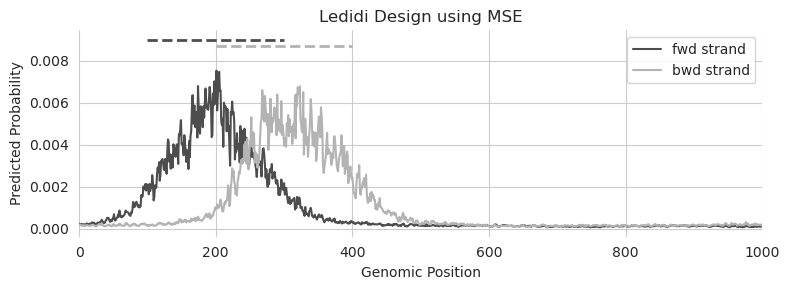

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

plt.figure(figsize=(8, 3))
plt.plot(y_hat[0, 0], c='0.3', label="fwd strand")
plt.plot(y_hat[0, 1], c='0.7', label="bwd strand")

plt.plot([100, 300], [0.0090, 0.0090], c='0.3', linestyle='--', linewidth=2)
plt.plot([200, 400], [0.0087, 0.0087], c='0.7', linestyle='--', linewidth=2)

plt.title("Ledidi Design using MSE")
plt.xlabel("Genomic Position")
plt.ylabel("Predicted Probability")

plt.xlim(0, 1000)
plt.legend()

seaborn.despine(bottom=True, left=True)
plt.tight_layout()
plt.show()

Great! Looks like we have peak predictions at the desired locations.

But is MSE the best loss to optimize here? BPNet intentionally chooses to use a different loss when optimizing the profile predictions because MSE has been shown to have weird artifacts when working with probabilities, like this. For example, note how much density of the predictions falls out of the desired range.

Maybe we can do better if we use a loss function that is explicitly meant to operate on probability distributions. KL-divergence has been shown to work well in this setting. To use a custom loss function, all we need to do is pass in a function to the `output_loss` parameter with the signature `f(y_hat, y_bar)` where `y_bar` is the desired output and `y_hat` is the predicted output given the current edited sequence. As a technical note, we are wrapping it a little bit because the implementation we are using reports the KL divergence for each example but we need the average divergence across all examples.

In [7]:
from bpnetlite.performance import _kl_divergence

kld = lambda x, y: _kl_divergence(y, x).mean()

X_hat = ledidi(model, X, y_bar, l=0.0, output_loss=kld, verbose=True)

iter=I	input_loss=0.0	output_loss=1.755	total_loss=1.755	time=0.0
iter=100	input_loss=751.0	output_loss=0.1578	total_loss=0.1578	time=1.26
iter=200	input_loss=702.8	output_loss=0.1326	total_loss=0.1326	time=1.282
iter=300	input_loss=760.6	output_loss=0.1126	total_loss=0.1126	time=1.258
iter=400	input_loss=762.8	output_loss=0.09138	total_loss=0.09138	time=1.258
iter=500	input_loss=776.6	output_loss=0.08533	total_loss=0.08533	time=1.262
iter=600	input_loss=793.1	output_loss=0.07705	total_loss=0.07705	time=1.254
iter=700	input_loss=800.4	output_loss=0.07333	total_loss=0.07333	time=1.256
iter=800	input_loss=823.8	output_loss=0.07241	total_loss=0.07241	time=1.255
iter=F	input_loss=807.0	output_loss=0.06802	total_loss=0.06802	time=10.29


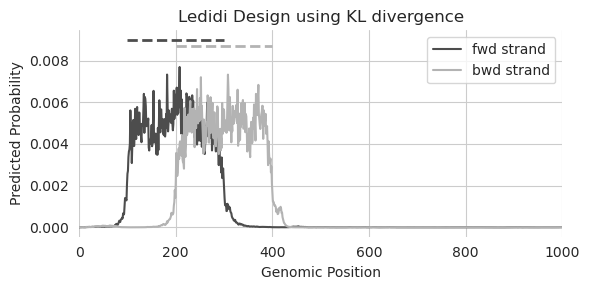

In [8]:
y_hat = predict(model, X_hat)

plt.figure(figsize=(6, 3))
plt.plot(y_hat[0, 0], c='0.3', label="fwd strand")
plt.plot(y_hat[0, 1], c='0.7', label="bwd strand")

plt.title("Ledidi Design using KL divergence")
plt.xlabel("Genomic Position")
plt.ylabel("Predicted Probability")

plt.plot([100, 300], [0.0090, 0.0090], c='0.3', linestyle='--', linewidth=2)
plt.plot([200, 400], [0.0087, 0.0087], c='0.7', linestyle='--', linewidth=2)

plt.xlim(0, 1000)
plt.legend()

seaborn.despine(bottom=True, left=True)
plt.tight_layout()
plt.show()

That looks remarkably sharper. Not only are both peaks at basically the same height, but they sharply decrease in predictions at the desired edges. It is likely, especially given the number of edits necessary to make these profiles, that the designed sequence will look sort of weird. But this is just a demonstration of (1) how to use a custom loss fnction and (2) the differences in output one might expect when using a loss function more tailored for the model output.

Let's try to take this one step further. Can we design edits that create two peaks where one peak is much stronger than the other?

In [9]:
y_bar = torch.zeros(1, 2, 1000).float()
y_bar[:, 0, 100:300] = 1
y_bar[:, 1, 200:400] = 1
y_bar[:, 0, 600:800] = 3
y_bar[:, 1, 700:900] = 3
y_bar /= y_bar.sum(dim=-1, keepdims=True)

X_hat = ledidi(model, X, y_bar, l=0.0, output_loss=kld, verbose=True)

iter=I	input_loss=0.0	output_loss=1.398	total_loss=1.398	time=0.0
iter=100	input_loss=718.0	output_loss=0.1765	total_loss=0.1765	time=1.259
iter=200	input_loss=722.9	output_loss=0.1369	total_loss=0.1369	time=1.259
iter=300	input_loss=748.1	output_loss=0.1254	total_loss=0.1254	time=1.258
iter=400	input_loss=778.4	output_loss=0.1056	total_loss=0.1056	time=1.256
iter=500	input_loss=757.3	output_loss=0.1188	total_loss=0.1188	time=1.257
iter=F	input_loss=763.6	output_loss=0.09379	total_loss=0.09379	time=7.296


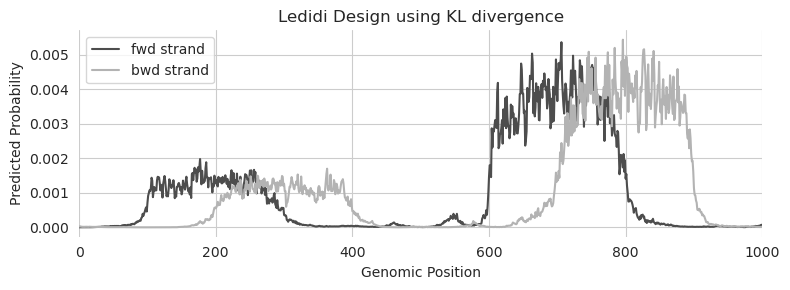

In [10]:
y_hat = predict(model, X_hat)

plt.figure(figsize=(8, 3))
plt.plot(y_hat[0, 0], c='0.3', label="fwd strand")
plt.plot(y_hat[0, 1], c='0.7', label="bwd strand")

plt.title("Ledidi Design using KL divergence")
plt.xlabel("Genomic Position")
plt.ylabel("Predicted Probability")

plt.xlim(0, 1000)
plt.legend()

seaborn.despine(bottom=True, left=True)
plt.tight_layout()
plt.show()

Looks like the answer is yes! Just because we have changed the output function to be KL divergence instead of MSE does not mean that we lose any flexibility to design edits with whatever properties we would like.

#### Unconstrained Rewards

A downside of using MSE in the multi-output setting is that we have to have a precise target value that we want to match for each of the outputs. Sometimes, this is the case and so using MSE is not a problem. However, other times, we may not have or even be able to reasonably guess what the output should be from each of the models. In these cases, we usually have a general sense that we would like designs that generally increase or decrease predictions from the models but do not know what the exact values should be. 

As a concrete example, consider the design of accessible sites whose accessibility is driven by a specific TF. In this setting, we likely have a target accessibility value (e.g., choosing a target that makes the region in the top percentile of accessible sites). But we may not know what the corresponding predictions should be for the TF model. This is because the dynamic range for each TF model will depend on the read depth and quality of the data used to train it and also because the effect on accessibility of the binding of each TF differs based on the structure and activity of the protein. For example, a pioneer factor will open chromatin significantly more than a "settler" factor. Trying to estimate the connection between TF binding and accessibility and then converting the desired accessibility value into a TF binding value is tricky: set the value too low and other TFs will be used to drive accessibility, set the value too high and suddenly you have an infeasible objective where either accessibility will be too high or TF binding will be too low.

A solution to this problem is to have an output loss function where some of the outputs have target values and other outputs are just rewarded for being higher or lower without constraint. In the previous example, we set a target accessibility value and then just reward higher predictions from the TF binding model without requiring that they meet a certain value. One way of viewing this is that there are many ways to design an accessible site and this approach pushes the designer towards those that utilize the binding of a specific TF.

To see this in action, let's load up a ChromBPNet model and a BPNet model that makes predictions for the binding of MAX.

In [11]:
from bpnetlite import BPNet
from bpnetlite.bpnet import CountWrapper

X = random_one_hot((1, 4, 2114), random_state=0).float()

chrombpnet = BPNet.from_chrombpnet("../../../../models/chrombpnet/fold_0/model.chrombpnet_nobias.fold_0.ENCSR868FGK.h5")
chrombpnet = CountWrapper(chrombpnet).cuda()

bpnet_max = torch.load("../../../../models/bpnet/MAX.torch", weights_only=False)
bpnet_max = CountWrapper(ControlWrapper(bpnet_max))

We can combine the two models and use them with Ledidi to design edits, just as we did in the multi-output tutorial.

In [12]:
from ledidi.wrappers import DesignWrapper

designer = DesignWrapper([chrombpnet, bpnet_max])

y_bar = torch.tensor([[13.0, 7.0]])

X_bar = ledidi(designer, X, y_bar, verbose=True)
y_hat = predict(designer, X_bar)
y_hat.mean(axis=0)

iter=I	input_loss=0.0	output_loss=26.07	total_loss=26.07	time=0.0
iter=100	input_loss=108.4	output_loss=1.235	total_loss=12.08	time=46.12
iter=200	input_loss=121.2	output_loss=0.6067	total_loss=12.73	time=24.36
iter=300	input_loss=114.0	output_loss=0.773	total_loss=12.17	time=24.37
iter=F	input_loss=99.06	output_loss=0.8359	total_loss=10.74	time=115.3


tensor([12.4062,  5.8811])

Looks like it is able to generate edits that gets close to the two targets.

Now, let's consider the alternate loss function. In this loss, we want to meet a desired output but we will also reward increases in MAX prediction. There are a few ones that one could implement this but probably the simplest is a function that takes in a `y_hat` tensor with two elements (accessibility and MAX predictions) and a `y_bar` tensor with one element (just the desired accessibility output), calculate a MSE loss on the accessibility component, and simply reward higher predictions from the MAX model.

In [13]:
def mse_max_loss(y_hat, y_bar):
    return torch.nn.MSELoss()(y_hat[: :1], y_bar) - y_hat[:, 1].mean()

A convenient aspect of framing the loss like this is that we do not have to make up some values for the "desired output" of MAX which we would then subsequently ignore. Rather, we are only passing in desired values for components that we actually want to control. Note that we are subtracting the MAX predictions (the second column in `y_hat`) because Ledidi minimizes the output loss and we want to maximize these predictions. Also note that we do not have to use the built-in MSE loss for the first component. As long as the function is differentiable we can do whatever we want. We are just using it here for convneience.

After specifying the output loss function, we can just pass that in like we did before.

In [14]:
X_bar = ledidi(designer, X, y_bar[:, :1], output_loss=mse_max_loss, verbose=True)

y_hat = predict(designer, X_bar)
y_hat.mean(axis=0)

iter=I	input_loss=0.0	output_loss=76.21	total_loss=76.21	time=0.0


/users/jacob.schreiber/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/users/jacob.schreiber/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


iter=100	input_loss=326.2	output_loss=1.18	total_loss=33.81	time=24.38
iter=200	input_loss=360.9	output_loss=-4.321	total_loss=31.77	time=24.39
iter=300	input_loss=354.4	output_loss=-4.972	total_loss=30.47	time=24.37
iter=400	input_loss=347.4	output_loss=-5.126	total_loss=29.62	time=24.38
iter=500	input_loss=344.4	output_loss=-6.973	total_loss=27.47	time=24.38
iter=600	input_loss=335.4	output_loss=-7.331	total_loss=26.21	time=24.38
iter=F	input_loss=329.9	output_loss=-7.888	total_loss=25.11	time=164.6


tensor([12.3439, 10.7223])

By using this loss function we are able to get much higher predictions of MAX while still getting the same accessibility predictions. Because the binding of many TFs (including MAX) subsequently cause an increase in accessibility, one can infer that having much higher predictions for MAX mean that other TFs must be binding less to achieve the same accessibility. Although we will not go deeper into it here, one can augment this approach by additionally using models for any of TF that might be relevant and rewarding low predictions from them. Together, that would yield designs that explicitly want higher MAX predictions and lower predictions of other TFs.

#### Cell Type-Specific Design and Min Gap

A common goal when designing elements is trying to create cell type-specific activity. This can be achieved in the default setting by setting high predicted values in the cell type(s) that one wants the element to be active in and low values in the cell type(s) that the element should not be active in. However, there can be two issues with simply using MSE to design specific elements like this. First, because MSE has a smoothing property (like we saw at the beginning of the notebok) is may not yield elements that are truly as specific as one might like. Second, an increasing amount of recent work has shown that the most cell type-specific elements are those that only exhibit weak signal and that making these regions stronger might risk making them less specific. Put another way: the target value for a cell type-specific element might be on a different range than the normal dynamic range of the model.

A potential solution to this wa proposed by Gosai <i>et al.</i> in what they called the "min gap." Essentially, the loss function involves maximizing the gap between (1) the minimum on-target value and (2) the maximum off-target value. A strength of this loss function is that it gets around the smoothing property of MSE. It does not matter if the elements are off in 9 out of 10 off-target cell lines. Each component of the loss is only as good as the <i>worse</i> element in that group.

Let's demonstrate this using the Malinois model from the same work.

In [15]:
from boda.model import BassetBranched

checkpoint = torch.load("../../../../models/malinois/torch_checkpoint.pt", weights_only=False)
malinois = BassetBranched(**vars(checkpoint['model_hparams']))
malinois.load_state_dict(checkpoint['model_state_dict'])

X = random_one_hot((1, 4, 600), random_state=0).float()

We can load the MinGap loss from `ledidi.losses`. Because there are two groups -- the on-target and the off-target outputs -- we have to pass in a binary vector indicating which elements are part of the on-target group. To support any composition of classes, `MinGap` is a `torch.nn.Module` instance that you pass a binary vector into and whose forward function is defned as the loss function. Here, let's say that we want to design edits that turn the sequence into something specific to the second output.

In [16]:
from ledidi.losses import MinGap

in_mask = torch.tensor([False, True, False])
output_loss = MinGap(in_mask)

An important aspect of the min gap loss is that there are no target values. This has two practical ramifications. First, there is nothing saying that the predictions have to be high in the on-target cell lines and low in the off-target ones. Because the loss only cares about maximizing the loss, both values could in theory be negative so long as the gap between them is high. Second, Ledidi's implementation expects something for `y_bar` even if that gets ignored by the loss. Here, we have to just make up some values but <i>they do not get used by min gap at all</i>

In [17]:
y_bar = torch.tensor([[0, 0, 0]])
X_bar = ledidi(malinois, X, y_bar, output_loss=output_loss, verbose=True)

y_hat = predict(malinois, X_bar)
y_hat.mean(axis=0)

iter=I	input_loss=0.0	output_loss=-0.1533	total_loss=-0.1533	time=0.0
iter=100	input_loss=92.38	output_loss=-21.22	total_loss=-11.98	time=0.8177
iter=200	input_loss=117.4	output_loss=-37.31	total_loss=-25.57	time=0.6526
iter=300	input_loss=123.6	output_loss=-38.47	total_loss=-26.11	time=0.6503
iter=400	input_loss=124.4	output_loss=-40.66	total_loss=-28.23	time=0.6506
iter=500	input_loss=120.2	output_loss=-41.29	total_loss=-29.27	time=0.6505
iter=600	input_loss=122.0	output_loss=-41.84	total_loss=-29.64	time=0.6471
iter=700	input_loss=124.6	output_loss=-42.18	total_loss=-29.72	time=0.6456
iter=800	input_loss=128.4	output_loss=-43.39	total_loss=-30.55	time=0.6451
iter=900	input_loss=126.2	output_loss=-42.93	total_loss=-30.31	time=0.6477
iter=F	input_loss=125.4	output_loss=-43.88	total_loss=-31.33	time=6.318


tensor([ 2.5212, 46.3993,  2.4737])

Looks like the predictions from the second output are significantly higher than the predictions from the other two outputs.

To show how general-purpose this loss is, let's say we want to make elements that are active in the first two but not the last output.

In [18]:
y_bar = torch.tensor([[0, 0, 0]])
X_bar = ledidi(malinois, X, y_bar, output_loss=MinGap(torch.tensor([True, True, False])), verbose=True)

y_hat = predict(malinois, X_bar)
y_hat.mean(axis=0)

iter=I	input_loss=0.0	output_loss=-0.2093	total_loss=-0.2093	time=0.0
iter=100	input_loss=66.06	output_loss=-12.86	total_loss=-6.255	time=0.6808
iter=200	input_loss=77.12	output_loss=-14.54	total_loss=-6.827	time=0.7468
iter=300	input_loss=85.38	output_loss=-15.81	total_loss=-7.273	time=0.6467
iter=F	input_loss=82.06	output_loss=-15.91	total_loss=-7.704	time=2.674


tensor([16.6600, 16.7327,  0.7471])

#### Assay-specific Design and Min Gap

As a side-note about the min gap loss, you do not have to use it only for cell type-specific design. More broadly, it can be used for <i>output-specific design</i> regardless of what those outputs are. If we combine two of our previous examples, let's say that we want to design elements that are TF specific. We can apply the min gap across TFs by designating them as either being on-target or off-target and design elements where the predictions should only be high for the on-target outputs.

In [19]:
bpnet_ctcf = torch.load("../../../../models/bpnet/CTCF.torch", weights_only=False)
bpnet_ctcf = CountWrapper(ControlWrapper(bpnet_ctcf))

bpnet_e2f6 = torch.load("../../../../models/bpnet/E2F6.torch", weights_only=False)
bpnet_e2f6 = CountWrapper(ControlWrapper(bpnet_e2f6))

bpnet_junb = torch.load("../../../../models/bpnet/JUNB.torch", weights_only=False)
bpnet_junb = CountWrapper(ControlWrapper(bpnet_junb))

designer = DesignWrapper([bpnet_max, bpnet_ctcf, bpnet_e2f6, bpnet_junb])

Just as before we can specify a min gap loss according to these four outputs. If we want to try designing something that is CTCF-specific all we need to do is set it to be the in-group and everything else to be the out-group.

In [20]:
X = random_one_hot((1, 4, 2114), random_state=0).float()

y_bar = torch.tensor([[0, 0, 0]])
X_bar = ledidi(designer, X, y_bar, l=0.001, output_loss=MinGap(torch.tensor([False, True, False, False])), verbose=True)

y_hat = predict(designer, X_bar)
y_hat.mean(axis=0)

iter=I	input_loss=0.0	output_loss=4.06	total_loss=4.06	time=0.0
iter=100	input_loss=744.4	output_loss=-4.478	total_loss=-3.734	time=5.709
iter=200	input_loss=868.8	output_loss=-6.906	total_loss=-6.038	time=5.703
iter=300	input_loss=869.7	output_loss=-7.69	total_loss=-6.82	time=5.703
iter=400	input_loss=878.2	output_loss=-8.609	total_loss=-7.731	time=5.704
iter=500	input_loss=911.9	output_loss=-9.325	total_loss=-8.414	time=5.717
iter=600	input_loss=932.3	output_loss=-9.352	total_loss=-8.42	time=5.703
iter=700	input_loss=970.6	output_loss=-9.956	total_loss=-8.985	time=5.702
iter=800	input_loss=996.0	output_loss=-9.996	total_loss=-9.0	time=5.706
iter=F	input_loss=1.005e+03	output_loss=-10.18	total_loss=-9.174	time=50.97


tensor([ 1.3769, 14.2045,  3.2331,  4.0257])

Looks like we are getting very strong predictions from the CTCF model and lower predictions from everything else.

We can also specify groups of proteins that we would like to have high values just by setting several values to True.

In [21]:
y_bar = torch.tensor([[0, 0, 0]])
X_bar = ledidi(designer, X, y_bar, l=0.001, output_loss=MinGap(torch.tensor([False, False, True, True])), verbose=True)

y_hat = predict(designer, X_bar)
y_hat.mean(axis=0)

iter=I	input_loss=0.0	output_loss=-0.9792	total_loss=-0.9792	time=0.0
iter=100	input_loss=422.1	output_loss=-5.737	total_loss=-5.315	time=5.718
iter=200	input_loss=548.4	output_loss=-6.782	total_loss=-6.233	time=5.709
iter=300	input_loss=598.2	output_loss=-7.302	total_loss=-6.704	time=5.706
iter=400	input_loss=625.4	output_loss=-7.944	total_loss=-7.318	time=5.711
iter=500	input_loss=655.7	output_loss=-8.127	total_loss=-7.472	time=5.705
iter=600	input_loss=670.2	output_loss=-8.68	total_loss=-8.009	time=5.706
iter=700	input_loss=663.0	output_loss=-8.955	total_loss=-8.292	time=5.711
iter=800	input_loss=660.1	output_loss=-9.117	total_loss=-8.457	time=5.708
iter=900	input_loss=661.3	output_loss=-9.458	total_loss=-8.796	time=5.707
iter=1000	input_loss=679.2	output_loss=-9.66	total_loss=-8.981	time=5.707
iter=F	input_loss=679.2	output_loss=-9.66	total_loss=-8.981	time=57.09


tensor([-0.9855, -0.9598,  8.7180,  8.7110])

A note when using min gap in the multi-model setting is making sure that the dynamic range of predicted values between the models is comparable. This is important because it will be challenging (if not impossible) to get an off-target model to predict a smaller value than an on-target model when the range of the off-target model is between 10 and 20 and the range of the on-target model is between 0 and 4. Because experimental artfiacts such as read depth and quality will influence the range of the predictions, one may wish to carefully inspect the models and potentially even z-score normalize the predictions to circumvent these potential issues.

#### Custom Loss for Less Specificity

A point that we have repeated about using MSE is that you have to set specific target values and that figuring out what these values should be can be challenging. One way to reduce the impact of this decision is to use a loss function that is more resistant to the precise target value and focuses more on getting in the right ballpark. As an example, we can define a custom "ballpark loss" that says a perfect match is anything within a radius of the target value. By using this loss, if you specify a desired value of 7.5, a predicted value of 7.2 is just as good as 7.5 -- you just want the predictions to be in the ballpark.

In [22]:
def ballpark_loss(y_hat, y_bar, z=1):    
    return torch.maximum(torch.nn.MSELoss(reduction='none')(y_hat, y_bar) - z, torch.zeros_like(y_hat))

We can take a look at the loss directly to see what the different curves look like.

/users/jacob.schreiber/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([101])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


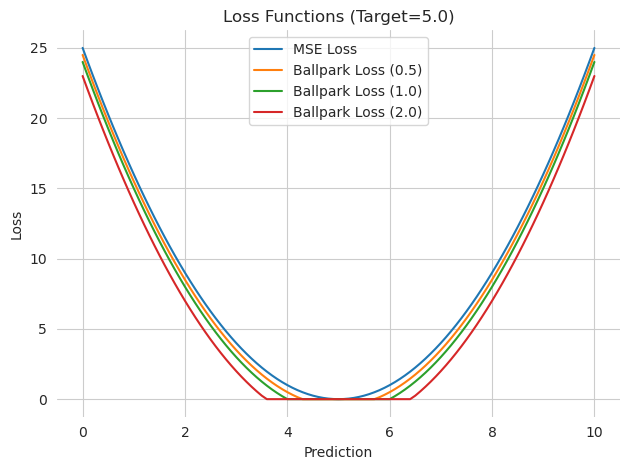

In [23]:
y = torch.tensor([5.0])
x = torch.arange(0, 10.1, 0.1)

loss1 = torch.nn.MSELoss(reduction='none')(x, y)
loss2 = ballpark_loss(x, y, 0.5).numpy(force=True)
loss3 = ballpark_loss(x, y, 1).numpy(force=True)
loss4 = ballpark_loss(x, y, 2).numpy(force=True)

plt.title("Loss Functions (Target=5.0)")
plt.plot(x, loss1, label="MSE Loss")
plt.plot(x, loss2, label="Ballpark Loss (0.5)")
plt.plot(x, loss3, label="Ballpark Loss (1.0)")
plt.plot(x, loss4, label="Ballpark Loss (2.0)")
plt.xlabel("Prediction")
plt.ylabel("Loss")

plt.legend()
seaborn.despine(bottom=True, left=True)
plt.tight_layout()
plt.show()

We can just plug the loss directly into Ledidi with the small modification that we need to take the mean to get a single number.

In [24]:
def ballpark_loss(y_hat, y_bar, z=1):    
    return torch.maximum(torch.nn.MSELoss(reduction='none')(y_hat, y_bar) - z, torch.zeros_like(y_hat)).mean()

y_bar = torch.tensor([[7.0]])
X_bar = ledidi(bpnet_ctcf, X, y_bar, output_loss=ballpark_loss, verbose=True)

y_hat = predict(bpnet_ctcf, X_bar)
y_hat.mean()

iter=I	input_loss=0.0	output_loss=44.93	total_loss=44.93	time=0.0
iter=100	input_loss=85.56	output_loss=1.468	total_loss=10.02	time= 1.2
iter=200	input_loss=93.56	output_loss=0.1706	total_loss=9.527	time=1.204
iter=300	input_loss=52.75	output_loss=0.1505	total_loss=5.425	time=1.201
iter=400	input_loss=48.0	output_loss=0.04736	total_loss=4.847	time=1.184
iter=500	input_loss=41.31	output_loss=0.007231	total_loss=4.138	time=1.182
iter=600	input_loss=43.44	output_loss=0.05472	total_loss=4.398	time=1.185
iter=700	input_loss=39.62	output_loss=0.1141	total_loss=4.077	time=1.183
iter=F	input_loss=34.44	output_loss=0.05474	total_loss=3.498	time=9.109


tensor(5.9989)

Looks like we get a value near 6. This is not particularly surprising because we had a target value of 7 and are giving it slack to be anywhere between 6 and 8. Because we are also penalizing edits, we end up near the lower end of the desired range because that requires making the fewest edits.

#### One-Directional Loss

Potentially, when specifying your loss, what you really want are designs that are that strong *or more extreme.* Basically, you want to make sure that the designs are at least some minimum strength but if the procedure is able to be better than that, even better! There are a few ways that this can be specified. First, we can just say that we will not penalize designs that are greater than the target value.

In [25]:
def one_directional_loss(y_hat, y_bar):
    return torch.where(y_hat < y_bar, torch.nn.MSELoss(reduction='none')(y_hat, y_bar), torch.zeros_like(y_hat)).mean()


y_bar = torch.tensor([[7.0]])
X_bar = ledidi(bpnet_ctcf, X, y_bar, l=0, output_loss=one_directional_loss, verbose=True)

y_hat = predict(bpnet_ctcf, X_bar)
y_hat.mean()

iter=I	input_loss=0.0	output_loss=45.93	total_loss=45.93	time=0.0
iter=100	input_loss=808.9	output_loss=0.7674	total_loss=0.7674	time=1.184
iter=200	input_loss=563.3	output_loss=0.0157	total_loss=0.0157	time=1.181
iter=F	input_loss=795.7	output_loss= 0.0	total_loss= 0.0	time=2.884


tensor(7.3477)

Another way that we could do this is to offer a reward for being above the desired output that is not as strong as the penalty for being below it.

In [26]:
def one_directional_loss(y_hat, y_bar):
    mse = torch.nn.MSELoss(reduction='none')(y_hat, y_bar)
    return torch.where(y_hat < y_bar, mse, -0.1 * mse).mean()


y_bar = torch.tensor([[7.0]])
X_bar = ledidi(bpnet_ctcf, X, y_bar, l=0, output_loss=one_directional_loss, verbose=True)

y_hat = predict(bpnet_ctcf, X_bar)
y_hat.mean()

iter=I	input_loss=0.0	output_loss=45.93	total_loss=45.93	time=0.0
iter=100	input_loss=782.8	output_loss=0.03437	total_loss=0.03437	time=1.181
iter=200	input_loss=606.1	output_loss=-0.002722	total_loss=-0.002722	time=1.178
iter=300	input_loss=857.7	output_loss=-0.8195	total_loss=-0.8195	time=1.18
iter=400	input_loss=971.6	output_loss=-1.479	total_loss=-1.479	time=1.178
iter=500	input_loss=1.018e+03	output_loss=-2.272	total_loss=-2.272	time=1.179
iter=600	input_loss=1.055e+03	output_loss=-2.686	total_loss=-2.686	time=1.177
iter=700	input_loss=1.092e+03	output_loss=-3.353	total_loss=-3.353	time=1.179
iter=800	input_loss=1.117e+03	output_loss=-3.812	total_loss=-3.812	time=1.178
iter=900	input_loss=1.145e+03	output_loss=-4.589	total_loss=-4.589	time=1.178
iter=1000	input_loss=1.16e+03	output_loss=-5.064	total_loss=-5.064	time=1.18
iter=F	input_loss=1.159e+03	output_loss=-5.171	total_loss=-5.171	time=11.79


tensor(14.1902)

In both examples, we set lambda to 0 so that we can see the true effects, but balancing lambda with the other terms of the loss will be important for design in practice. Regardless, this is just another example of how creative one can be when coming up with custom losses.